In [96]:
disable_warnings = True
if disable_warnings:
    import warnings
    warnings.filterwarnings('ignore')

import pickle
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns

from utils.ICL_utils import ICLDataset
from utils.model_utils import ExtendedLanguageModel

from utils.plot_utils import plot_RDM
from utils.eval_utils import *

from __future__ import print_function
from ipywidgets import interactive


ABSTRACT_DIR = 'data/ICL/results/abstractive/'
CONCEPTNET_DIR = 'data/ICL/results/conceptnet/'
PROWISE_DIR = 'data/multiple_choice/internals'

In [97]:
# Select Model
model_widget = interactive(lambda model_name: model_name,
                      model_name=[
                            'meta-llama/Llama-2-70b-hf',
                            'EleutherAI/gpt-j-6b'
                      ])
display(model_widget)

interactive(children=(Dropdown(description='model_name', options=('meta-llama/Llama-2-70b-hf', 'EleutherAI/gpt…

In [98]:
model_name = model_widget.children[0].value
model = ExtendedLanguageModel(model_name)
print(f"Selected model: {model_name}\n")

Selected model: meta-llama/Llama-2-70b-hf



In [99]:
results_path = f'{ABSTRACT_DIR}/{model.nickname}__{3}_n.pkl'
data = pickle.load(open(results_path, 'rb'))
data_loader = ICLDataset(dataset='antonym', size=100, n_prepended=3, bidirectional=False, padded_space=False, seed=42)
print(data_loader.prompts[0])

Q: heterosexual
A: homosexual

Q: head
A: tail

Q: strengthening
A: weakening

Q: intentional
A: 


In [144]:
np.array_equal(1-(1-rdm), rdm)

True

In [100]:
n_train_sizes = [5,3,2,1]
RDMsFV = []
accuracy = {}
for idx in range(len(n_train_sizes)): 
    # Load data
    results_path = f'{ABSTRACT_DIR}/{model.nickname}__{n_train_sizes[idx]}_n.pkl'
    data = pickle.load(open(results_path, 'rb'))

    # Get RDMs
    FVs = np.concatenate([data[dataset]['FVs'] for dataset in data.keys()])
    rdm = get_RDM(FVs)
    RDMsFV.append(rdm)
    
    # Get avg accuracy
    accuracy_n_train = []
    for dataset in data.keys():
        accuracy_dataset = accuracy_completions(model, data[dataset]['completions'], data[dataset]['Ys'])
        accuracy_n_train.append(accuracy_dataset)

    accuracy[n_train_sizes[idx]] = accuracy_n_train

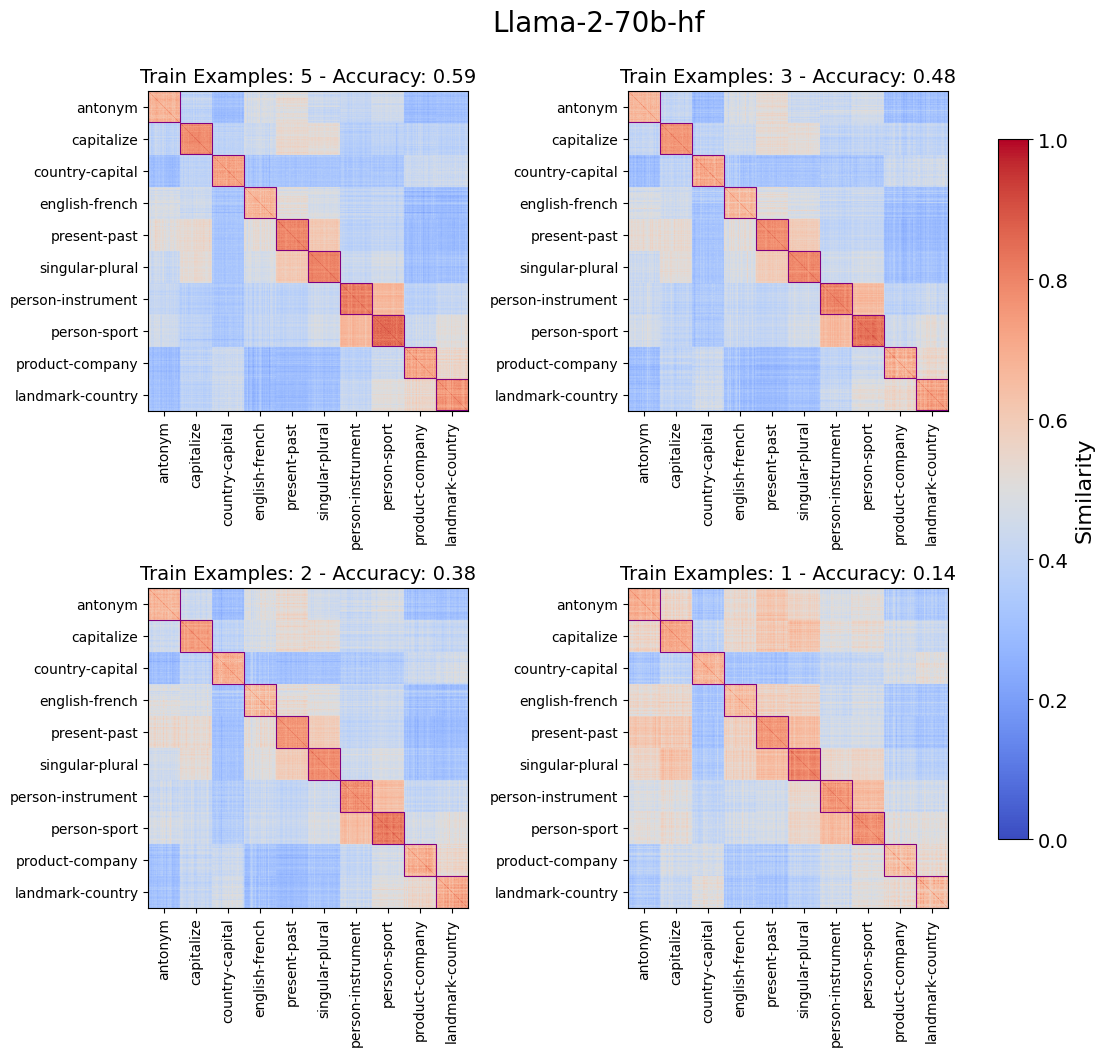

In [101]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

tasks = np.repeat(list(data.keys()), len(data[list(data.keys())[0]]['completions']))
task_idx = get_unique_indices(pd.Series(tasks))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axes_flat = axes.flatten()
norm = Normalize(vmin=0, vmax=1)

# Iterate over each RDM and plot it on the corresponding subplot
for idx, ax in enumerate(axes_flat):
    rdm = RDMsFV[idx]
    plot_RDM(rdm, 
             axis=ax, 
             title=f'Train Examples: {n_train_sizes[idx]} - Accuracy: {np.mean(accuracy[n_train_sizes[idx]]):.2f}', 
             rel_indices=task_idx, 
             rel_ticks=True,
             norm=norm,
    )

# Create a colorbar
fig.subplots_adjust(right=0.85, left=0.05, bottom=0.05, top=0.93, wspace=0.5, hspace=0.3)
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7]) 
cbar = fig.colorbar(ScalarMappable(norm=norm, cmap='coolwarm'), cax=cbar_ax)
cbar.set_label('Similarity', fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.suptitle(model.nickname, fontsize=20)
plt.show()

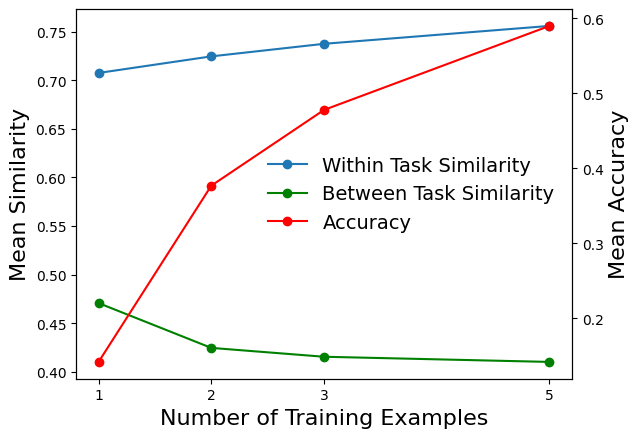

In [102]:
sim_within = [within_task_similarity(1-rdm, task_idx) for rdm in RDMsFV]
sim_between = [between_task_similarity(1-rdm, task_idx) for rdm in RDMsFV]
sim_ratio = np.array(sim_within) / np.array(sim_between)
acc_mean = [np.mean(accuracy[n_train]) for n_train in n_train_sizes]

fig, ax = plt.subplots()
line1, = ax.plot(n_train_sizes, sim_within, label='Within Task Similarity', marker='o')
line2, = ax.plot(n_train_sizes, sim_between, label='Between Task Similarity', marker='o', color='green')
ax2 = ax.twinx()
line3, = ax2.plot(n_train_sizes, acc_mean, label='Accuracy', color='red', marker='o')
ax2.set_ylabel('Mean Accuracy', fontsize=16)

ax.set_xticks(n_train_sizes)
ax.set_xlabel('Number of Training Examples', fontsize=16)
ax.set_ylabel('Mean Similarity', fontsize=16)

lines = [line1, line2, line3]
ax.legend(lines, [l.get_label() for l in lines], fontsize=14, frameon=False)

plt.show()

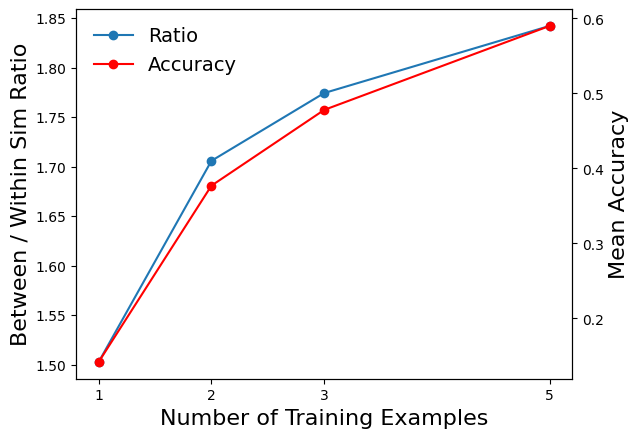

In [103]:
fig, ax = plt.subplots()
line1, = ax.plot(n_train_sizes, sim_ratio, label='Ratio', marker='o')
ax2 = ax.twinx()
line2, = ax2.plot(n_train_sizes, acc_mean, label='Accuracy', marker='o', color='red')

ax.set_xticks(n_train_sizes)
ax.set_xlabel('Number of Training Examples', fontsize=16)
ax.set_ylabel('Between / Within Sim Ratio', fontsize=16)
ax2.set_ylabel('Mean Accuracy', fontsize=16)

# Combine legends from both axes into one
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, fontsize=14, frameon=False)

plt.show()

In [104]:
prowise = np.load(f'{PROWISE_DIR}/analogies_prowise_ENG__{model.nickname}.npy')

In [105]:
results_path = f'{ABSTRACT_DIR}/{model.nickname}__{n_train_sizes[0]}_n.pkl'
data = pickle.load(open(results_path, 'rb'))
FVs = np.concatenate([data[dataset]['FVs'] for dataset in data.keys()])

In [106]:
n_random = 100 #len(prowise)
random_indices = np.random.choice(prowise.shape[0], n_random, replace=False)
prowise_sample = prowise[random_indices]
vecs = np.concatenate([FVs, prowise_sample])
rdm = get_RDM(vecs)

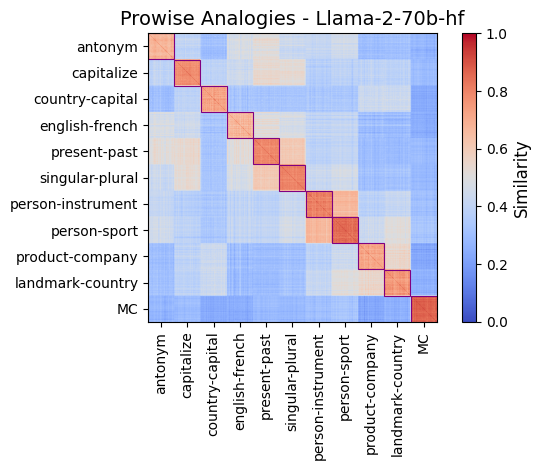

In [107]:
task_idx['MC'] = (FVs.shape[0], FVs.shape[0] + prowise_sample.shape[0]-1)
plot_RDM(rdm,
            title=f'Prowise Analogies - {model.nickname}',
            rel_indices=task_idx,
            rel_ticks=True,
            norm=norm,
    )

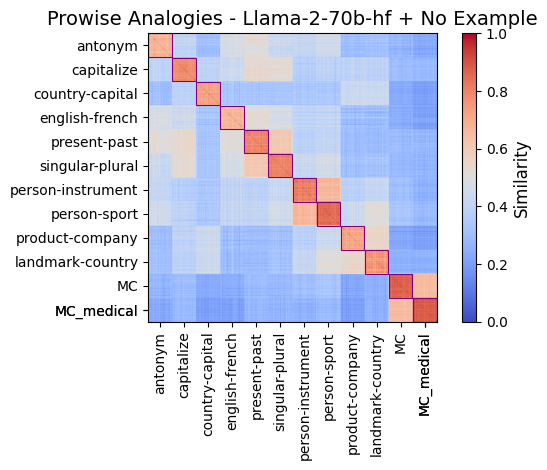

In [111]:
no_example_vecs= np.load(f'{PROWISE_DIR}/no_example/analogies_prowise_ENG__{model.nickname}.npy')
vecs_extended = np.concatenate([vecs, no_example_vecs])
rdm = get_RDM(vecs_extended)

task_idx['MC_no_example'] = (vecs.shape[0], vecs.shape[0] + no_example_vecs.shape[0]-1)
plot_RDM(rdm,
            title=f'Prowise Analogies - {model.nickname} + No Example',
            rel_indices=task_idx,
            rel_ticks=True,
            norm=norm,
    )

In [110]:
task_idx

{'antonym': (0, 99),
 'capitalize': (100, 199),
 'country-capital': (200, 299),
 'english-french': (300, 399),
 'present-past': (400, 499),
 'singular-plural': (500, 599),
 'person-instrument': (600, 699),
 'person-sport': (700, 799),
 'product-company': (800, 899),
 'landmark-country': (900, 999),
 'MC': (1000, 1099),
 'MC_no_example': (1100, 1199),
 'MC_medical': (1100, 1199)}

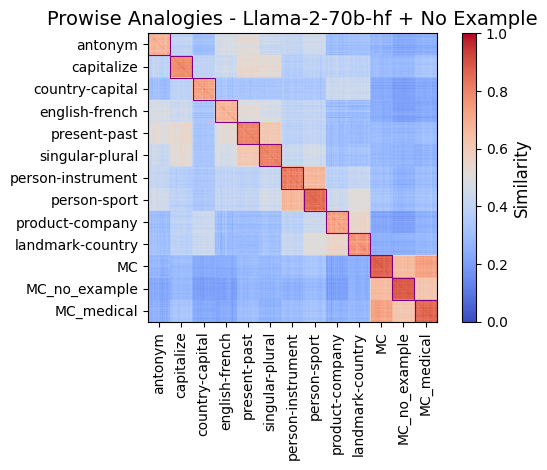

In [112]:
mcmed_vecs= pickle.load(open(f'data/medmcqa/{model.nickname}.pkl', 'rb'))['FVs']
vecs_extended_mcmed = np.concatenate([vecs_extended, mcmed_vecs])
rdm = get_RDM(vecs_extended_mcmed)

task_idx['MC_medical'] = (vecs_extended.shape[0], vecs_extended.shape[0] + mcmed_vecs.shape[0]-1)
plot_RDM(rdm,
            title=f'{model.nickname} + Medical MCQA',
            rel_indices=task_idx,
            rel_ticks=True,
            norm=norm,
        )

In [120]:
task_idx

{'antonym': (0, 99),
 'capitalize': (100, 199),
 'country-capital': (200, 299),
 'english-french': (300, 399),
 'present-past': (400, 499),
 'singular-plural': (500, 599),
 'person-instrument': (600, 699),
 'person-sport': (700, 799),
 'product-company': (800, 899),
 'landmark-country': (900, 999),
 'MC': (1000, 1099),
 'MC_no_example': (1100, 1199),
 'MC_medical': (1200, 1299)}

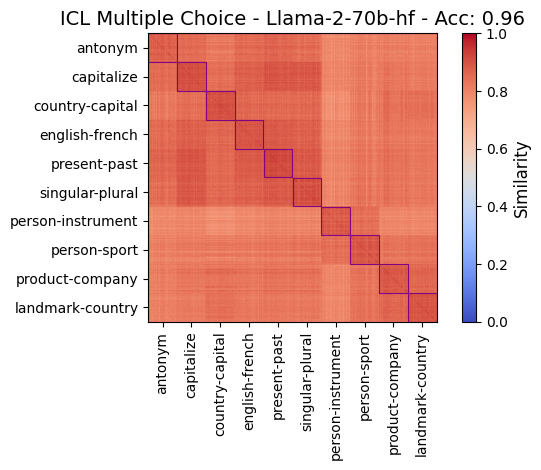

In [136]:
icl_mc = pickle.load(open(f'data/ICL/results/abstractive/multiple_choice/{model.nickname}__3_n.pkl', 'rb'))
icl_mc_vecs = np.concatenate([icl_mc[dataset]['FVs'] for dataset in icl_mc.keys()])
rdm = get_RDM(icl_mc_vecs)



plot_RDM(rdm,
        title=f'ICL Multiple Choice - {model.nickname} - Acc: {np.mean(accuracy_icl_mc):.2f}',
        norm=norm,
        rel_indices={task:idx for task, idx in task_idx.items() if 'MC' not in task},
        )

In [131]:
accuracy_icl_mc = []
for dataset in icl_mc.keys():
    correct = []
    for completion, y in zip(icl_mc[dataset]['completions'], icl_mc[dataset]['Ys']):
        correct_completion_first_token = model.tokenizer.tokenize(y)[0].replace('▁', '')
        correct.append(completion == correct_completion_first_token)
    accuracy_icl_mc.append(sum(correct) / len(correct))

In [134]:
icl_mc[dataset]['completions']

['b',
 'd',
 'b',
 'b',
 'd',
 'c',
 'b',
 'a',
 'c',
 'd',
 'd',
 'a',
 'b',
 'a',
 'b',
 'b',
 'd',
 'b',
 'c',
 'd',
 'a',
 'b',
 'd',
 'c',
 'b',
 'c',
 'b',
 'b',
 'b',
 'd',
 'd',
 'a',
 'b',
 'd',
 'a',
 'a',
 'a',
 'b',
 'b',
 'b',
 'b',
 'b',
 'd',
 'b',
 'b',
 'b',
 'd',
 'a',
 'a',
 'd',
 'c',
 'b',
 'd',
 'c',
 'a',
 'c',
 'a',
 'a',
 'c',
 'b',
 'a',
 'd',
 'd',
 'c',
 'd',
 'c',
 'b',
 'b',
 'c',
 'b',
 'b',
 'd',
 'a',
 'c',
 'c',
 'a',
 'a',
 'c',
 'a',
 'a',
 'c',
 'c',
 'b',
 'c',
 'c',
 'd',
 'd',
 'c',
 'c',
 'a',
 'd',
 'c',
 'a',
 'd',
 'a',
 'a',
 'b',
 'd',
 'a',
 'b']

In [135]:
icl_mc[dataset]['Ys']

['b',
 'd',
 'b',
 'b',
 'd',
 'c',
 'b',
 'a',
 'c',
 'd',
 'd',
 'a',
 'b',
 'a',
 'b',
 'b',
 'd',
 'b',
 'c',
 'd',
 'a',
 'b',
 'd',
 'c',
 'b',
 'c',
 'b',
 'b',
 'b',
 'd',
 'd',
 'a',
 'b',
 'd',
 'a',
 'a',
 'a',
 'b',
 'b',
 'b',
 'b',
 'c',
 'd',
 'b',
 'b',
 'b',
 'd',
 'a',
 'a',
 'd',
 'c',
 'b',
 'd',
 'c',
 'a',
 'c',
 'a',
 'a',
 'c',
 'b',
 'a',
 'd',
 'd',
 'c',
 'd',
 'c',
 'b',
 'b',
 'c',
 'b',
 'b',
 'd',
 'a',
 'c',
 'c',
 'a',
 'a',
 'c',
 'a',
 'a',
 'c',
 'c',
 'b',
 'c',
 'c',
 'd',
 'd',
 'c',
 'c',
 'a',
 'd',
 'c',
 'a',
 'd',
 'a',
 'a',
 'b',
 'c',
 'a',
 'b']

In [133]:
y

'b'

In [132]:
accuracy_icl_mc

[0.98, 0.99, 1.0, 1.0, 0.99, 1.0, 0.8, 0.91, 0.94, 0.98]

In [129]:
accuracy

{5: [0.54, 0.75, 0.72, 0.56, 0.48, 0.73, 0.18, 0.61, 0.53, 0.8],
 3: [0.41, 0.54, 0.64, 0.38, 0.35, 0.66, 0.11, 0.53, 0.43, 0.73],
 2: [0.33, 0.33, 0.63, 0.26, 0.34, 0.62, 0.11, 0.31, 0.25, 0.59],
 1: [0.07, 0.02, 0.21, 0.1, 0.19, 0.35, 0.03, 0.17, 0.09, 0.19]}

In [124]:
icl_mc

{'antonym': {'FVs': array([[-0.55651742,  0.65231353, -0.3503201 , ..., -0.28170371,
           0.26795933, -0.04350823],
         [-0.72716916,  0.86751568, -0.42220008, ..., -0.80664313,
           0.47524333, -0.37017512],
         [ 0.19672243, -0.02436355, -0.02110671, ..., -0.3241027 ,
           0.32844064, -0.20738268],
         ...,
         [-0.35135949,  0.39895421,  0.01055603, ..., -0.34466058,
           0.33485997,  0.17612453],
         [-0.1481097 ,  0.1235657 , -0.1072726 , ..., -0.38023254,
           0.52401912,  0.03510181],
         [ 0.26196864,  0.15850766,  0.32477361, ..., -0.07170525,
           0.18435496, -0.61320883]]),
  'completions': ['c',
   'b',
   'a',
   'd',
   'd',
   'c',
   'a',
   'b',
   'd',
   'b',
   'c',
   'b',
   'a',
   'a',
   'b',
   'b',
   'b',
   'c',
   'a',
   'b',
   'd',
   'c',
   'b',
   'b',
   'a',
   'd',
   'a',
   'c',
   'a',
   'a',
   'a',
   'b',
   'd',
   'a',
   'a',
   'c',
   'd',
   'b',
   'b',
   'b',
   'b',

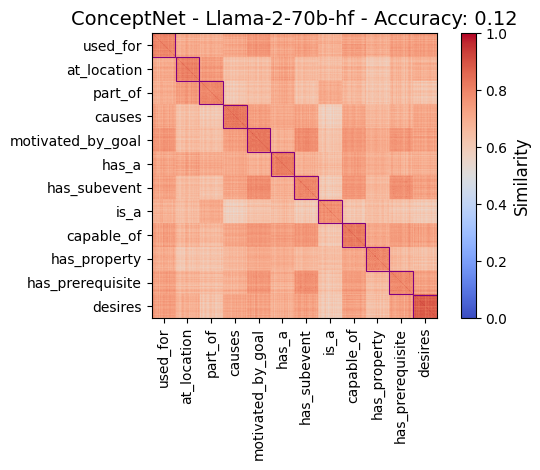

In [73]:
results_path = f'{CONCEPTNET_DIR}/{model.nickname}__{5}_n.pkl'
data = pickle.load(open(results_path, 'rb'))

FVs = np.concatenate([data[dataset]['FVs'] for dataset in data.keys()])

tasks = np.repeat(list(data.keys()), len(data[list(data.keys())[0]]['completions']))
task_idx_conceptnet = get_unique_indices(pd.Series(tasks))

# Get accuracy per dataset
accuracy_conceptnet = []
for dataset in data.keys():
    correct = []
    for completion, y in zip(data[dataset]['completions'], data[dataset]['Ys']):
        correct_completion_first_token = model.tokenizer.tokenize(y)[0].replace('▁', '')
        correct.append(completion == correct_completion_first_token)
    accuracy_conceptnet.append(sum(correct) / len(correct))

rdm_conceptnet = get_RDM(FVs)
plot_RDM(rdm_conceptnet,
            title=f'ConceptNet - {model.nickname} - Accuracy: {np.mean(accuracy_conceptnet):.2f}',
            rel_indices=task_idx,
            rel_ticks=True,
            norm=norm,
    )

In [60]:
sim_within = within_task_similarity(1-rdm_conceptnet, task_idx)
sim_between = between_task_similarity(1-rdm_conceptnet, task_idx)
sim_ratio = np.array(sim_within) / np.array(sim_between)

In [61]:
sim_ratio

1.170512765302142

In [71]:
# Get accuracy per dataset
accuracy_conceptnet = []
for dataset in data.keys():
    correct = []
    for completion, y in zip(data[dataset]['completions'], data[dataset]['Ys']):
        correct_completion_first_token = model.tokenizer.tokenize(y)[0].replace('▁', '')
        correct.append(completion == correct_completion_first_token)
    accuracy_conceptnet.append(sum(correct) / len(correct))


In [72]:
accuracy_conceptnet 

[0.07, 0.05, 0.37, 0.01, 0.09, 0.09, 0.07, 0.4, 0.11, 0.1, 0.03, 0.0]

In [63]:
np.mean(rdm_conceptnet)

0.3020053268347739

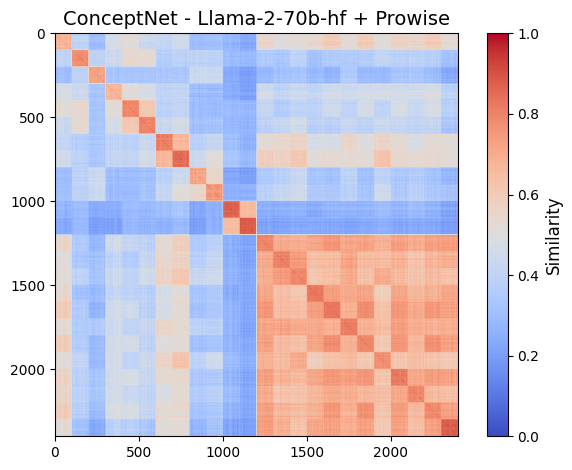

In [67]:
rdm_ = get_RDM(np.concatenate([vecs_extended, FVs]))
plot_RDM(rdm_,
            title=f'ConceptNet - {model.nickname} + Prowise',
            rel_indices=None,
            norm=norm,
    )